In [1]:
%%capture
!pip install gpjax
!pip install beartype
!pip install -U tensorflow_probability

In [2]:
import jax

jax.config.update("jax_enable_x64", True)
from beartype.typing import Callable, Tuple
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import gpjax as gpx
from jaxtyping import Float64, Array
import beartype.typing as tp
from beartype import beartype


plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]
key = jr.PRNGKey(123)

/var/folders/yw/lshmc3054xz63j1qgg7c74680000gr/T/ipykernel_45329/3805258738.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Using GPJax

In the previous demo we saw how one can implement a GP using JAX. In this demo we're going to fit more complex regression models using GPJax. To get us started, let's first simulate a training dataset. To do this, we'll first define a GP prior using GPJax, and then draw a single sample from it.


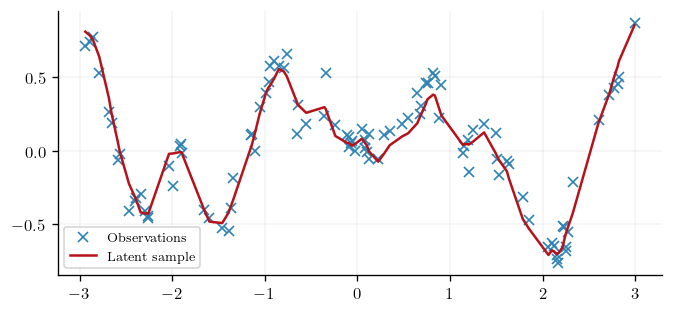

In [19]:
N = 100
true_lengthscale = 0.75
true_variance = 0.5
true_noise = 0.1
kernel = gpx.kernels.Matern32(lengthscale=true_lengthscale, variance=true_variance)

# The points at which we'd like to evaluate the prior
X = jnp.sort(jr.uniform(key, shape=(N, 1), minval=-3.0, maxval=3.0), axis=0)

# Defining the prior
_prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=kernel)
prior_mvn = _prior.predict(X)  # A 100-dimensional Gaussian
prior_sample = prior_mvn.sample(seed=key, sample_shape=(1,)).T

# Applying iid Gaussian noise to the prior sample
key, subkey = jr.split(key)
noise = jr.normal(subkey, shape=(N, 1)) * true_noise
y = prior_sample + noise

D = gpx.Dataset(X=X, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500)[:, None]

# Plot our sample
fig, ax = plt.subplots()
ax.plot(X, y, "x", label="Observations")
ax.plot(X, prior_sample, label="Latent sample")
ax.legend()

## Fitting a GP Regression Model

To instantiate the GP prior in GPJax, we must specify the mean function and kernel that parameterise our GP prior. With this, we are then able to define the prior.

## Exercise 1

Define a GP prior, draw samples from the prior, and plot the samples. Repeat this for several different kernels and observe the differing functions that each kernel induces.

Tip: to list all the kernels implemented in GPJax, run `gpx.kernels.__all__`.


In [14]:
# Solution here.

For the posterior, we must also specify the likelihood function. As we are carrying out GP regression in this example, a Gaussian likelihood will be assumed. Once we have a prior and a likelihood, we are able to instantiate the posterior distribution. We see this below.


In [25]:
prior = gpx.gps.Prior(
    mean_function=gpx.mean_functions.Zero(), kernel=gpx.kernels.Matern52()
)

likelihood = gpx.likelihoods.Gaussian(num_datapoints=N)

posterior = prior * likelihood

## Exercise 2

Similar to Exercise 1, now draw samples from the posterior distribution and compare them to the samples drawn from the prior distribution.


In [27]:
# Solution here

## Marginal Log-Likelihood


Now that we have a posterior distribution defined, we would like to optimise its parameters and obtain Type-II MLEs, as we did in the first notebook. Achieving this in GPJax is straightforward as we simply instantiate the `ConjugateMLL` object and evaluate it for a given posterior distribution and dataset.


In [28]:
D = gpx.Dataset(X=X, y=y)
negative_mll = gpx.objectives.ConjugateMLL(negative=True)

negative_mll(posterior, train_data=D)

Array(104.22637436, dtype=float64)

## Exercise 3

As we saw in the first session, one may differentiate against the marginal log-likelihood to obtain Type-II maximum likelihood estimates for the kernel and likelihood parameters. Using Jax's `grad` or `value_and_grad`, now compute derivatives of the marginal log-likelihood.


In [31]:
# Solution here.

We'll use GPJax's convenient `fit` function to optimise the parameters of our GP. Under-the-hood, this is performing gradient descent in a very similar manner to what we saw in the first demo.


In [32]:
import optax as ox

opt = ox.adam(learning_rate=0.01)

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=jax.jit(negative_mll),
    train_data=D,
    optim=opt,
    key=key,
    num_iters=500,
)

  0%|          | 0/500 [00:00<?, ?it/s]

## Exercise 4

Plt the marginal log-likelihood's evaluations and establish whether or not the optimisation converged.


We can inspect the MLL that was obtained at each step of the optimisation routine to check for convergence.


In [33]:
# Solution here

## Exercise 5

Once you're happy that the optimisation has converged, evaluate the predictive mean and predictive standard deviation of the posterior predictive distribution.

Looks good! Now let's compute the predictive posterior distribution for our GP. We'll do this by first defining a test dataset, and then using the `predict` function. This function takes in a posterior distribution and a test dataset, and returns the predictive posterior distribution for the test dataset.


In [34]:
# Solution here

We can also plot the distribution, as we did before.


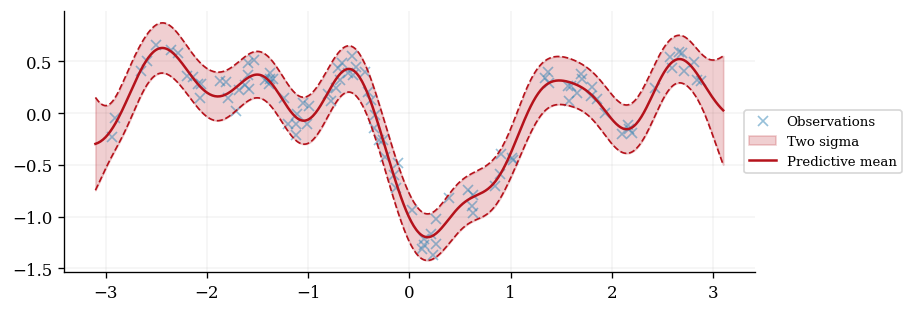

In [13]:
def plot_predictions(X, y, xtest, predictive_mean, predictive_std):
    fig, ax = plt.subplots(figsize=(7.5, 2.5))
    ax.plot(X, y, "x", label="Observations", color=cols[0], alpha=0.5)
    ax.fill_between(
        xtest.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        xtest,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        xtest,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))


plot_predictions(X, y, xtest, predictive_mean, predictive_std)

## Exercise 6

Propose alternative parameterisations of your Gaussian process and fit them. Compare the final marginal log-likelihood values that you obtain. What do you notice? When is the marginal log-likelihood maximised. Note: the printout from `fit` is the negative MLL, so here you'd seek the minimiser.


## Modelling Real-World Data

We support a large number of kernels in GPJax. A convenient property of kernels is that they are closed under addition and multiplication. This allows us to combine kernels to capture more complex structures in the data. In this section, we shall do this to model the Mauna Loa dataset. To get started, let's first load and inspect the data.


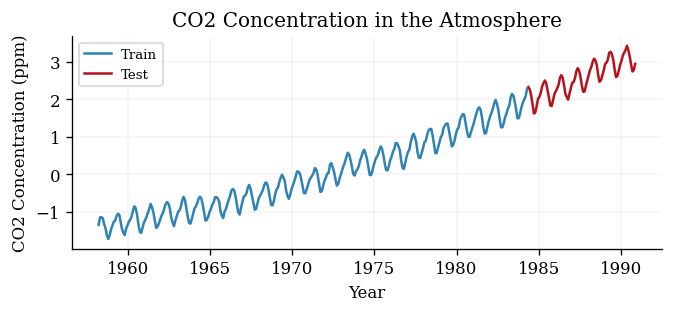

In [14]:
co2_data = pd.read_csv(
    "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv", comment="#"
)
co2_data = co2_data.loc[co2_data["decimal date"] < 1990 + 11 / 12]

# Partition into a train and test set
Ntrain = int(co2_data.shape[0] * 0.8)
Xtr = co2_data["decimal date"].values[:Ntrain, None]
Xte = co2_data["decimal date"].values[Ntrain:, None]
ytr = co2_data["average"].values[:Ntrain, None]
yte = co2_data["average"].values[Ntrain:, None]

# Standardise the response
yscaler = StandardScaler()
ytr = yscaler.fit_transform(ytr)
yte = yscaler.transform(yte)

# Store the data in a Dataset object
co2_data = gpx.Dataset(X=Xtr, y=ytr)

# Plot the data
fig, ax = plt.subplots()
ax.plot(Xtr, ytr, label="Train")
ax.plot(Xte, yte, label="Test")
ax.set_title("CO2 Concentration in the Atmosphere")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 Concentration (ppm)")
ax.legend()

Clearly there's some complex correlation present in this data, but let's try a simple stationary kernel first to see how it performs.


  0%|          | 0/500 [00:00<?, ?it/s]

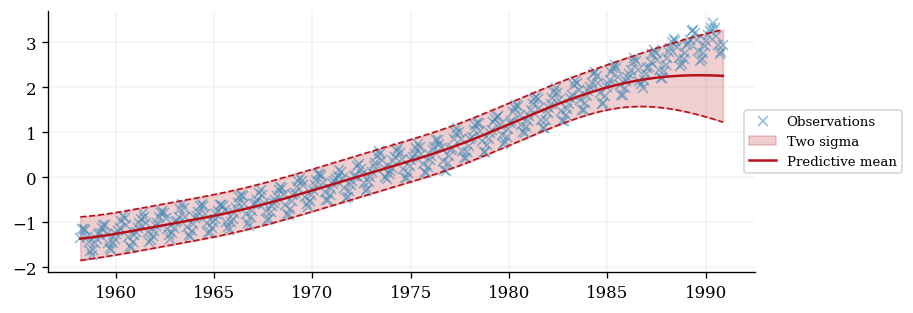

In [15]:
# Define the prior
kernel = gpx.kernels.Matern52()
meanf = gpx.mean_functions.Constant()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

# Instantiate the likelihood and posterior
likelihood = gpx.likelihoods.Gaussian(num_datapoints=co2_data.n)
posterior = prior * likelihood

# Optimise the posterior w.r.t. the MLL
mll = jax.jit(gpx.objectives.ConjugateMLL(negative=True).step)
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=mll,
    train_data=co2_data,
    optim=ox.adamw(learning_rate=0.1),
    num_iters=500,
    key=key,
)

# Let's predict at all points
latent_dist = opt_posterior.predict(jnp.vstack([Xtr, Xte]), train_data=co2_data)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

plot_predictions(
    jnp.vstack([Xtr, Xte]),
    jnp.vstack([ytr, yte]),
    jnp.vstack([Xtr, Xte]),
    predictive_mean,
    predictive_std,
)

Clearly this is not the behaviour that we would like from our GP.

## Exercise 7

Using the above, try and design a better kernel and mean function for the data. Note that two kernels can be summed or multiplied in GPJax using the `+` and `*` operators respectively. To see the list of available kernels you may print the `gpx.kernels.__all__` variable.


In [35]:
# Solution here